# Import Python Libraries 

In [47]:
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from PIL import Image
from pathlib import Path
import numpy as np
from datetime import datetime
from flask import Flask, request, render_template

In [48]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Tensorflow Version 2.15.0 is Used

In [49]:
import tensorflow as tf
print(tf.__version__)

2.15.0


### Create a Class For Extracting Feature. Based on these Feature our Model is going to show output

In [50]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)

        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize


### Extrating the feature from the Images

In [51]:
if __name__ == '__main__':
    fe = FeatureExtractor()

    for img_path in sorted(Path("./static/img").glob("*.jpg")):
        print(img_path)
        feature = fe.extract(img=Image.open(img_path))
        feature_path = Path("./static/feature") / (img_path.stem + ".npy")
        np.save(feature_path, feature)

static\img\Blue_Cir.jpg
1/1 [==============================] - 3s 3s/step
static\img\Blue_Rect.jpg
1/1 [==============================] - 0s 375ms/step
static\img\Blue_Tri.jpg
1/1 [==============================] - 0s 390ms/step
static\img\Green_Cir.jpg
1/1 [==============================] - 0s 437ms/step
static\img\Green_Rect.jpg
1/1 [==============================] - 0s 390ms/step
static\img\Green_Tri.jpg
1/1 [==============================] - 0s 373ms/step
static\img\Red_Cir.jpg
1/1 [==============================] - 0s 362ms/step
static\img\Red_Rect.jpg
1/1 [==============================] - 0s 475ms/step
static\img\Red_Tri.jpg
1/1 [==============================] - 1s 607ms/step


1/1 [==============================] - 2s 2s/step


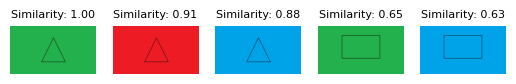

In [58]:
import os
import matplotlib.pyplot as plt

def find_similar_images(query_image, dataset_path, top_n=5):
    fe = FeatureExtractor()

    query_features = fe.extract(query_image)
    
    image_paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.lower().endswith(('.jpg', '.jpeg'))]
    
    similarities = []

    for image_path in image_paths:
        features = np.load(os.path.join("./static/feature", f"{Path(image_path).stem}.npy"))
        similarity = np.dot(query_features, features) / (np.linalg.norm(query_features) * np.linalg.norm(features))
        similarities.append((image_path, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    for i in range(min(top_n, len(similarities))):
        similar_image_path, similarity_score = similarities[i]
        similar_image = Image.open(similar_image_path)

        plt.subplot(1, top_n, i + 1)
        plt.imshow(similar_image)
        plt.title(f"Similarity: {similarity_score:.2f}", fontsize = 8)
        plt.axis('off')

    plt.show()

user_input_image_path = 'static/img/Green_Tri.jpg'  # Change this to the actual path or input from the user
user_input_image = Image.open(user_input_image_path)

dataset_path = './static/img'

find_similar_images(user_input_image, dataset_path, top_n=5)
